<a href="https://colab.research.google.com/github/MohanBhandari/Gait-Analysis-MLE/blob/master/RHA_C7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import (absolute_import, division,print_function, unicode_literals)
from builtins import *
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
df = pd.read_csv("/content/drive/My Drive/RAH.csv")

In [31]:
print(df)

       Frame  Time (Seconds)         X  ...       X.7       Y.7       Z.7
0          0        0.000000  0.097579  ...  0.095676  1.180708  0.173109
1          1        0.008333  0.097454  ...  0.095623  1.180723  0.172862
2          2        0.016667  0.097516  ...  0.095702  1.180692  0.172755
3          3        0.025000  0.097568  ...  0.095715  1.180609  0.172615
4          4        0.033333  0.097671  ...  0.095589  1.180442  0.172454
...      ...             ...       ...  ...       ...       ...       ...
36740  36740      306.166667  0.078853  ...  0.102311  1.195289  0.448971
36741  36741      306.175000  0.077401  ...  0.101109  1.195786  0.449457
36742  36742      306.183333  0.076332  ...  0.099910  1.196282  0.450070
36743  36743      306.191667  0.075272  ...  0.098704  1.196777  0.450614
36744  36744      306.200000  0.074067  ...  0.097466  1.197138  0.451028

[36745 rows x 26 columns]


In [46]:

xs=df.loc[:,'X'].values
ys=df.loc[:,'Y'].values
zs=df.loc[:,'Z'].values
print(xs[0],ys[0],zs[0])
dt = 0.01
num_steps = 36744

0.097579 1.306857 0.20937600000000003


In [47]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

(36745,)


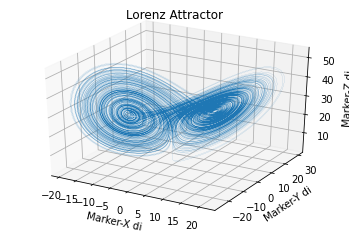

In [48]:
#xs[0], ys[0], zs[0] = (0.097413, 0.030524, -0.055748)
x_1=[]
y_1=[]
z_1=[]

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)
    x_1.append(x_dot)
    y_1.append(y_dot)
    z_1.append(z_dot)
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
print(xs.shape)
#print(zs[0],zs[10],zs[1000],zs[10000],zs[20000],zs[30000],zs[34175])
ax.plot(xs, ys, zs, lw=0.09)
ax.set_xlabel("Marker-X di")
ax.set_ylabel("Marker-Y di")
ax.set_zlabel("Marker-Z di")
ax.set_title("Lorenz Attractor")
plt.show()

In [49]:
from_L=[x_1,y_1,z_1]
from_L_T=(np.asarray(from_L).T)
from_L_fit = StandardScaler().fit_transform(from_L_T)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(from_L_fit)
final_data=principalComponents[np.logical_not(np.isnan(principalComponents))]
print(final_data)
print(final_data.shape)


[-0.21831892 -0.23738637 -0.26021161 ... -2.05176831 -1.92609013
 -1.78281963]
(36744,)


In [50]:
def rowwise_euclidean(x, y):
    return np.sqrt(np.sum((x - y)**2, axis=1))

In [51]:
def poly_fit(x, y, degree, fit="RANSAC"):
    # check if we can use RANSAC
    if fit == "RANSAC":
        try:
              # ignore ImportWarnings in sklearn
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", ImportWarning)
                import sklearn.linear_model as sklin
                import sklearn.preprocessing as skpre
        except ImportError:
            warnings.warn("fitting mode 'RANSAC' requires the package sklearn, using"+ " 'poly' instead",RuntimeWarning)
            fit = "poly"
    if fit == "poly":
        return np.polyfit(x, y, degree)
    elif fit == "RANSAC":
        model = sklin.RANSACRegressor(sklin.LinearRegression(fit_intercept=False))
        xdat = np.asarray(x)
        if len(xdat.shape) == 1:
          # interpret 1d-array as list of len(x) samples instead of
          # one sample of length len(x)
            xdat = xdat.reshape(-1, 1)
        polydat = skpre.PolynomialFeatures(degree).fit_transform(xdat)
        try:
            model.fit(polydat, y)
            coef = model.estimator_.coef_[::-1]
        except ValueError:
            warnings.warn("RANSAC did not reach consensus, "+ "using numpy's polyfit",RuntimeWarning)
            coef = np.polyfit(x, y, degree)
        return coef
    else:
        raise ValueError("invalid fitting mode ({})".format(fit))

In [52]:
def delay_embedding(data, emb_dim, lag=1):
    data = np.asarray(data)
    min_len = (emb_dim - 1) * lag + 1
    if len(data) < min_len:
        msg = "cannot embed data of length {} with embedding dimension {} " \
        + "and lag {}, minimum required length is {}"
        raise ValueError(msg.format(len(data), emb_dim, lag, min_len))
    m = len(data) - min_len + 1
    indices = np.repeat([np.arange(emb_dim) * lag], m, axis=0)
    indices += np.arange(m).reshape((m, 1))
    return data[indices]

In [53]:
def lyap_r_len(**kwargs):
    # minimum length required to find single orbit vector
    min_len = (kwargs['emb_dim'] - 1) * kwargs['lag'] + 1
    # we need trajectory_len orbit vectors to follow a complete trajectory
    min_len += kwargs['trajectory_len'] - 1
    # we need min_tsep * 2 + 1 orbit vectors to find neighbors for each
    min_len += kwargs['min_tsep'] * 2 + 1
    return min_len

In [54]:
def lyap_r(data, emb_dim=10, lag=None, min_tsep=None, tau=1, min_neighbors=20,trajectory_len=100, fit="RANSAC", debug_plot=False, debug_data=False,plot_file=None, fit_offset=0):
    # convert data to float to avoid overflow errors in rowwise_euclidean
    data = np.asarray(data, dtype="float32")
    n = len(data)
   
    max_tsep_factor = 0.25
    if lag is None or min_tsep is None:
        # both the algorithm for lag and min_tsep need the fft
        f = np.fft.rfft(data, n * 2 - 1)
    if min_tsep is None:
        # calculate min_tsep as mean period (= 1 / mean frequency)
        mf = np.fft.rfftfreq(n * 2 - 1) * np.abs(f)
        mf = np.mean(mf[1:]) / np.sum(np.abs(f[1:]))
        min_tsep = int(np.ceil(1.0 / mf))
        if min_tsep > max_tsep_factor * n:
            min_tsep = int(max_tsep_factor * n)
            msg = "signal has very low mean frequency, setting min_tsep = {:d}"
            warnings.warn(msg.format(min_tsep), RuntimeWarning)
    if lag is None:
        # calculate the lag as point where the autocorrelation drops to (1 - 1/e)
        # times its maximum value
        # note: the Wiener–Khinchin theorem states that the spectral
        # decomposition of the autocorrelation function of a process is the power
        # spectrum of that process
        # => we can use fft to calculate the autocorrelation
        acorr = np.fft.irfft(f * np.conj(f))
        acorr = np.roll(acorr, n - 1)
        eps = acorr[n - 1] * (1 - 1.0 / np.e)
        lag = 1
        # small helper function to calculate resulting number of vectors for a
        # given lag value
        def nb_neighbors(lag_value):
            min_len = lyap_r_len(emb_dim=emb_dim, lag=i, trajectory_len=trajectory_len,min_tsep=min_tsep)
            return max(0, n - min_len)
        # find lag
        for i in range(1,n):
            lag = i
            if acorr[n - 1 + i] < eps or acorr[n - 1 - i] < eps:
                break
            if nb_neighbors(i) < min_neighbors:
                msg = "autocorrelation declined too slowly to find suitable lag setting lag to {}"
                warnings.warn(msg.format(lag), RuntimeWarning)
                break
    min_len = lyap_r_len(emb_dim=emb_dim, lag=lag, trajectory_len=trajectory_len,min_tsep=min_tsep)
    if len(data) < min_len:
        msg = "for emb_dim = {}, lag = {}, min_tsep = {} and trajectory_len = {}" \
              + " you need at least {} datapoints in your time series"
        warnings.warn(msg.format(emb_dim, lag, min_tsep, trajectory_len, min_len),RuntimeWarning)
    # delay embedding
    orbit = delay_embedding(data, emb_dim, lag)
    
    m = len(orbit)
    
    # construct matrix with pairwise distances between vectors in orbit
    dists = np.array([rowwise_euclidean(orbit, orbit[i]) for i in range(m)])
    # we do not want to consider vectors as neighbor that are less than min_tsep
    # time steps together => mask the distances min_tsep to the right and left of
    # each index by setting them to infinity (will never be considered as nearest
    # neighbors)
    for i in range(m):
        dists[i, max(0, i - min_tsep):i + min_tsep + 1] = float("inf")
    # check that we have enough data points to continue
    ntraj = m - trajectory_len + 1
    min_traj = min_tsep * 2 + 2 # in each row min_tsep + 1 disances are inf
    if ntraj <= 0:
        msg = "Not enough data points. Need {} additional data points to follow " \
            + "a complete trajectory."
        raise ValueError(msg.format(-ntraj+1))
    if ntraj < min_traj:
        # not enough data points => there are rows where all values are inf
        assert np.any(np.all(np.isinf(dists[:ntraj, :ntraj]), axis=1))
        msg = "Not enough data points. At least {} trajectories are required " \
                + "to find a valid neighbor for each orbit vector with min_tsep={} " \
                + "but only {} could be created."
        raise ValueError(msg.format(min_traj, min_tsep, ntraj))
    assert np.all(np.any(np.isfinite(dists[:ntraj, :ntraj]), axis=1))
    # find nearest neighbors (exclude last columns, because these vectors cannot
    # be followed in time for trajectory_len steps)
    nb_idx = np.argmin(dists[:ntraj, :ntraj], axis=1)

    # build divergence trajectory by averaging distances along the trajectory
    # over all neighbor pairs
    div_traj = np.zeros(trajectory_len, dtype=float)
    for k in range(trajectory_len):
        # calculate mean trajectory distance at step k
        indices = (np.arange(ntraj) + k, nb_idx + k)
        div_traj_k = dists[indices]
        # filter entries where distance is zero (would lead to -inf after log)
        nonzero = np.where(div_traj_k != 0)
        if len(nonzero[0]) == 0:
            # if all entries where zero, we have to use -inf
            div_traj[k] = -np.inf
        else:
            div_traj[k] = np.mean(np.log(div_traj_k[nonzero]))
    # filter -inf entries from mean trajectory
    ks = np.arange(trajectory_len)
    finite = np.where(np.isfinite(div_traj))
    ks = ks[finite]
    div_traj = div_traj[finite]
    if len(ks) < 1:
        # if all points or all but one point in the trajectory is -inf, we cannot
        # fit a line through the remaining points => return -inf as exponent
        poly = [-np.inf, 0]
    else:
        # normal line fitting
        poly = poly_fit(ks[fit_offset:], div_traj[fit_offset:], 1, fit=fit)
    if debug_plot:
        plot_reg(ks[fit_offset:], div_traj[fit_offset:], poly, "k", "log(d(k))", fname=plot_file)
    le = poly[0] / tau
    if debug_data:
        return (le, (ks, div_traj, poly))
    else:
        return le,div_traj,dists

In [55]:
%%time
MLE, div_traj,orbit=(lyap_r(final_data, 
                            emb_dim=10, lag=None, min_tsep=None, 
                            tau=1, min_neighbors=20,trajectory_len=2000, 
                            fit="RANSAC", debug_plot=False, debug_data=False,
                            plot_file=None, fit_offset=0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 9186


CPU times: user 54.6 s, sys: 1min 29s, total: 2min 24s
Wall time: 2min 24s


In [56]:
print(MLE)

1.6420009363072182e-05


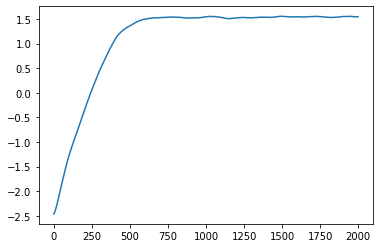

In [57]:
plt.plot(div_traj)